In [396]:
import numpy as np
import matplotlib.pyplot as plt
import random
import enum

# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

N - количество осей (размерность) <br>
M - количество точек <br>
minValue - минимальное значение для иксов <br>
maxValue - максимальное значение для иксов

In [397]:
N = 1
M = 30
minValue = 0
maxValue = 5
beta_1 = 0.9
beta_2 = 0.999

class TypeOfOptimisation(enum.Enum):
    none = 0
    momentum = 1
    Nesterov = 2
    RMSProp = 3
    AdaGrad = 4
    Adam = 5

a = np.array([1, 2])
print(np.sqrt(a))

[1.         1.41421356]


In [398]:
def y_regression(B, X):
    return np.sum(X * B)


B_reg = []
for ind in range(N + 1):
    bi = random.randint(-maxValue, maxValue)
    B_reg.append(bi)
B_reg = np.array(B_reg, dtype='float64')
print(B_reg)
XM = []
YM = []
YR = []
for ind in range(M):
    X = [1]
    for j in range(N):
        X.append(ind)
    X = np.array(X)
    rand_delta = random.randint(-maxValue, maxValue)
    Y_act = y_regression(B_reg, X) + rand_delta
    YM.append(Y_act)
    XM.append(np.array(X))
XM = np.array(XM, dtype='float64')
YM = np.array(YM)


def runSGD(typeOfOptimisation, withNormalization, lr, eps):
    B_start = np.array([0] * (N + 1), dtype='float64')
    YR = np.array([0] * M, dtype='float64')
    if withNormalization:
        X_norm = ZNormalization(XM)
        Y_norm = (YM - np.mean(YM)) / np.std(YM)
        BA_start = (B_reg - np.mean(B_reg)) / np.std(B_reg)
        BF_norm, \
        errors_norm, \
        YF_norm, \
        iterations = gradient_descent(1,
                                      X_norm,
                                      Y_norm,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      TypeOfOptimisation.none,
                                      with_normalization=True)

        print(errors_norm[0], errors_norm[len(errors_norm) - 1])
        print("actual coefficients:     ", BA_start)
        print("calculated coefficients: ", BF_norm)
        print("number of iterations:    ", iterations)
        drawGraph(X_norm, Y_norm, YF_norm)
        draw_errors_graphic(errors_norm, iterations)
    else:
        B_final, \
        errors, \
        YF, \
        iterations = gradient_descent(1,
                                      XM,
                                      YM,
                                      YR,
                                      B_start,
                                      lr,
                                      eps,
                                      typeOfOptimisation,
                                      with_normalization=False)

        print(errors[0], errors[len(errors) - 1])
        print("actual coefficients:     ", B_reg)
        print("calculated coefficients: ", B_final)
        print("number of iterations:    ", iterations)
        drawGraph(XM, YM, YF)
        draw_errors_graphic(errors, iterations)

[3. 2.]


15.6289 2.377770976780119
actual coefficients:      [3. 2.]
calculated coefficients:  [0.09732463 2.15806091]
number of iterations:     7


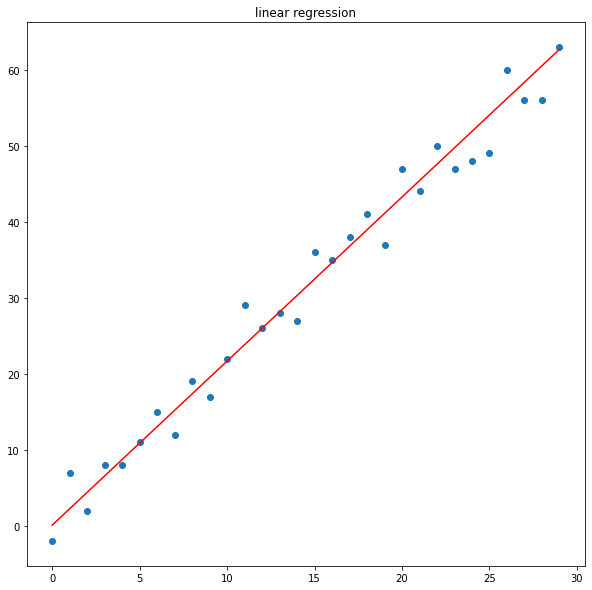

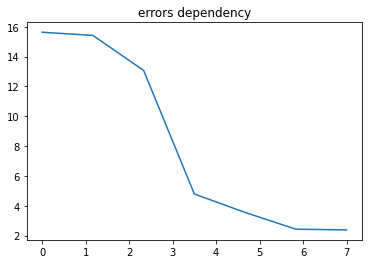

In [399]:
def mean_error(Y_act, Y_reg):
    return np.sum(abs(Y_act - Y_reg)) / M


def stopping_criteria(previous, current, eps):
    return abs(previous - current) < eps


def gradient(nums, XM, YR, YM):
    grad = []
    for i in range(N + 1):
        xi = 0
        for k in range(len(nums)):
            xi += XM[nums[k]][i] * (YR[nums[k]] - YM[nums[k]])
            if xi > 1e25:
                return np.array([0] * (N + 1), dtype='float64')
        grad.append(xi)
    return np.array(grad)


def gradient_descent(batch, XM, YM, YR, B_reg, lr, eps, type_of_optimisation, with_normalization):
    previous_error = 0
    grad = np.array([0] * (N + 1), dtype='float64')
    previous_gradient = np.array([0] * (N + 1), dtype='float64')
    m_adam = np.array([0] * (N + 1), dtype='float64')
    v_adam = np.array([0] * (N + 1), dtype='float64')
    errors = []
    iterations = 0
    new_grad = np.array([0] * (N + 1), dtype='float64')
    while True:
        nums = set()
        while len(nums) != batch:
            x = random.randint(0, M - 1)
            if x not in nums:
                nums.add(x)
        nums = np.array(list(nums))

        # :NOTE: optimisations
        if type_of_optimisation == TypeOfOptimisation.none:
            grad = gradient(nums, XM, YR, YM)
        elif type_of_optimisation == TypeOfOptimisation.momentum:
            grad = gradient(nums, XM, YR, YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.Nesterov:
            B_prev = B_reg - lr * previous_gradient
            YR_new = [0] * M
            for i in range(M):
                YR_new[i] = y_regression(B_prev, XM[i])
            grad = gradient(nums, XM, np.array(YR_new), YM)
            grad += gamma * previous_gradient
        elif type_of_optimisation == TypeOfOptimisation.AdaGrad:
            grad = gradient(nums, XM, YR, YM)
            new_grad += np.square(grad)
            grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
        elif type_of_optimisation == TypeOfOptimisation.RMSProp:
            grad = gradient(nums, XM, YR, YM)
            new_grad = gamma * new_grad + (1 - gamma) * np.square(grad)
            grad = np.divide(grad, np.sqrt(abs(new_grad + eps)))
        elif type_of_optimisation == TypeOfOptimisation.Adam:
            grad = gradient(nums, XM, YR, YM)
            m_adam = beta_1 * m_adam + (1 - beta_1) * grad
            v_adam = beta_2 * v_adam + (1 - beta_2) * np.square(grad)
            m = m_adam / (1 - beta_1)
            v = v_adam / (1 - beta_2)
            grad = m / np.sqrt(abs(v + eps))
        B_reg -= lr * grad

        for i in range(M):
            YR[i] = y_regression(B_reg, XM[i])
        if stopping_criteria(previous_error, mean_error(YM, YR), with_normalization, eps):
            break
        previous_error = mean_error(YM, YR)
        previous_gradient = grad
        errors.append(previous_error)
        iterations += 1
    return B_reg, errors, YR, iterations


def drawGraph(XM, YM, YF):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    X = XM.T[1]
    plt.scatter(X, YM)
    plt.plot(X, YF, color='red')
    plt.title('linear regression')
    plt.show()


def draw_errors_graphic(E, iterations):
    i = np.linspace(0, iterations, iterations)
    plt.plot(i, E)
    plt.title('errors dependency')
    plt.show()


runSGD(TypeOfOptimisation.none, withNormalization=False, lr=1e-3, eps=1e-3)

# Задание 2

0.8631508860667135 0.12807199321688562
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-0.00561439  0.94999706]
number of iterations:     335


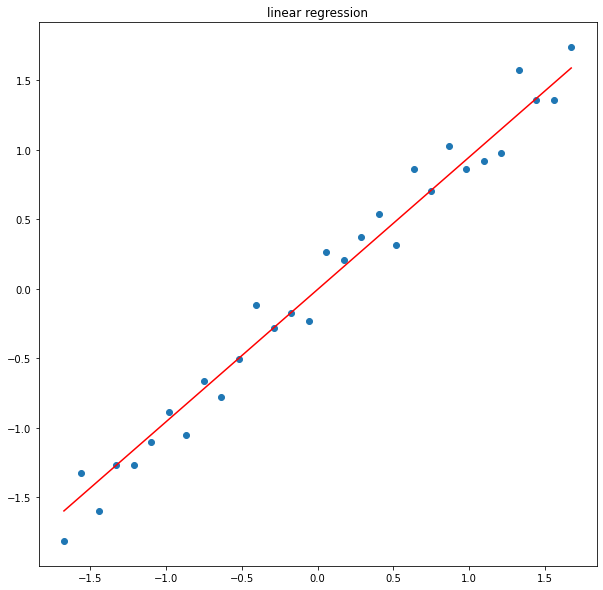

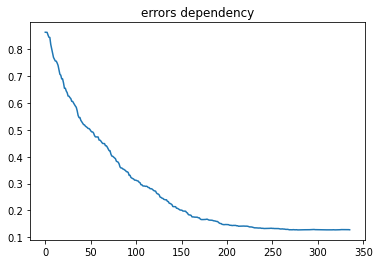

In [400]:
def ZNormalization(XM):
    X = XM.T
    for i in range(1, N + 1):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    return X.T


# print(XM)
runSGD(TypeOfOptimisation.none, withNormalization=True, lr=1e-2, eps=1e-6)

# Задание 3

### Метод моментов

Смысл заключается в том, что мы на каждом шаге прибавляем к значению градиента
предыдущий градиент умноженный на константу. Это позволяет градиентному спуску не застревать
в локальных минимумах.

30.720344086021505 2.3404609588457617
actual coefficients:      [3. 2.]
calculated coefficients:  [31.07064836 17.57531169]
number of iterations:     1686
0.8441664481527336 0.129190033182207
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-0.00485754  0.94149367]
number of iterations:     288


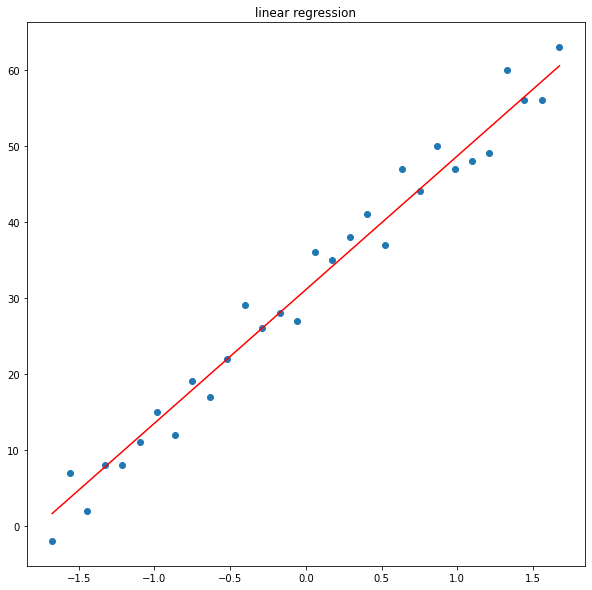

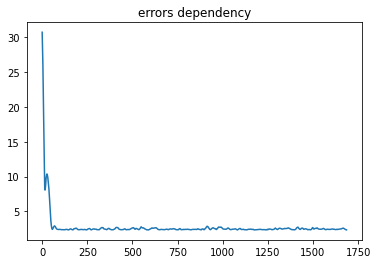

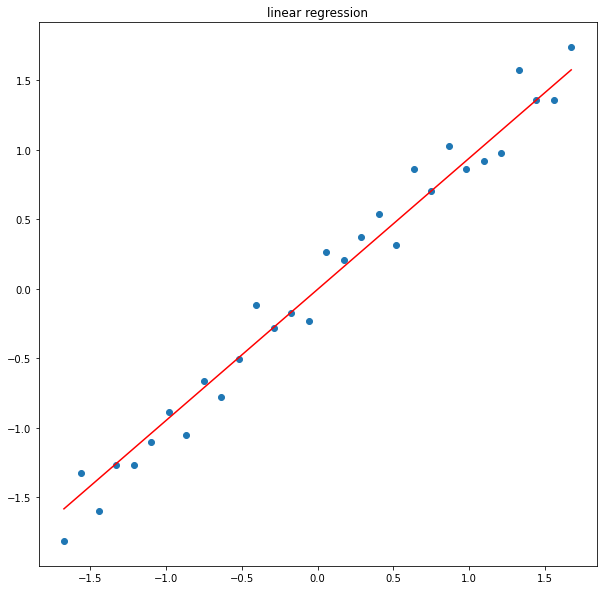

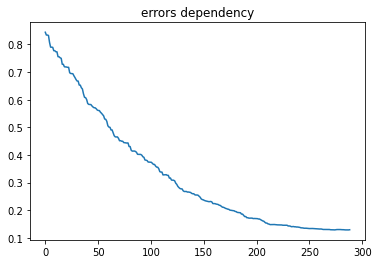

In [401]:
gamma = 0.9

runSGD(TypeOfOptimisation.momentum, withNormalization=False, lr=1e-2, eps=1e-6)
runSGD(TypeOfOptimisation.momentum, withNormalization=True, lr=1e-2, eps=1e-6)

### Метод Нестерова

Здесь используется тот же смысл, как и в методе моментов, только градиент мы считаем не от текущей точки,
а от следующей (как бы заглядывая вперед). Дает более быструю сходимость, чем метод моментов.

30.966408602150537 2.3501806181918976
actual coefficients:      [3. 2.]
calculated coefficients:  [31.18465096 17.89988039]
number of iterations:     9829
0.8690688237857935 0.15843463881496075
actual coefficients:      [ 1. -1.]
calculated coefficients:  [0.01508928 0.85902043]
number of iterations:     222


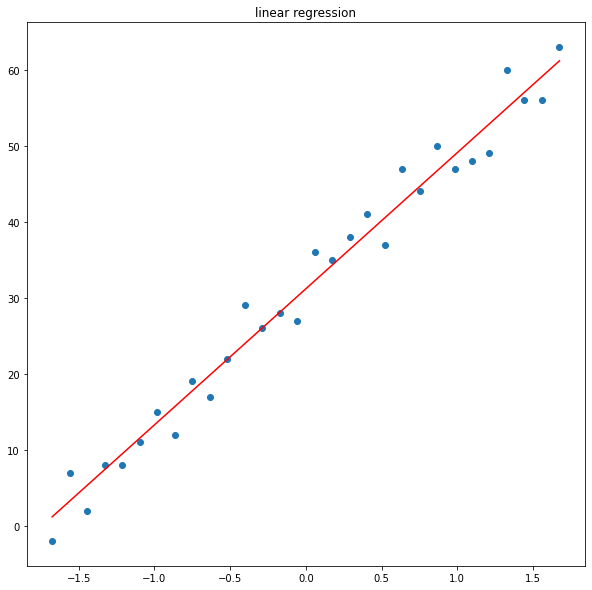

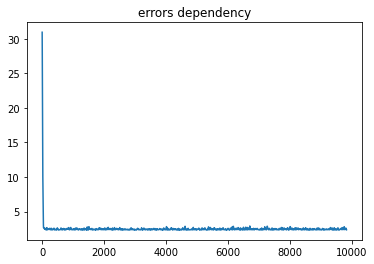

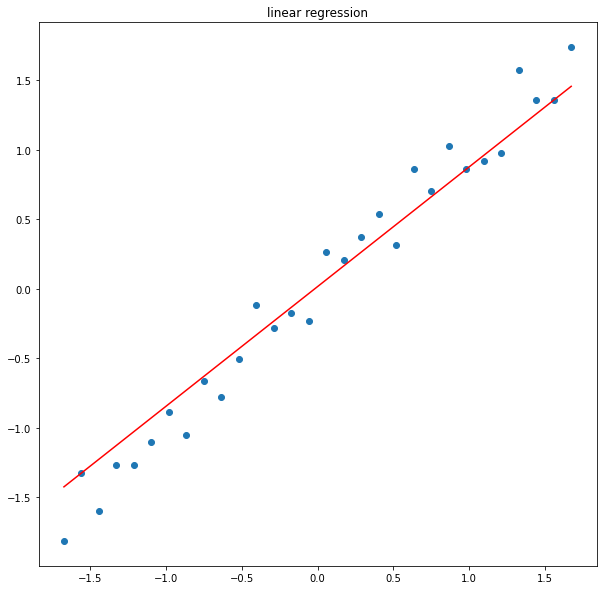

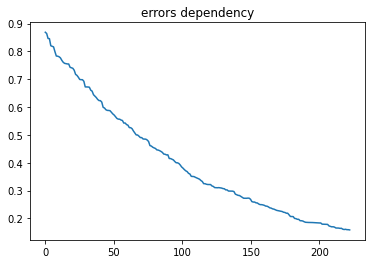

In [402]:
runSGD(TypeOfOptimisation.Nesterov, withNormalization=False, lr=1e-2, eps=1e-6)
runSGD(TypeOfOptimisation.Nesterov, withNormalization=True, lr=1e-2, eps=1e-6)

### AdaGrad

31.3251168312226 27.271178937849548
actual coefficients:      [3. 2.]
calculated coefficients:  [4.09379411 2.16040619]
number of iterations:     59344
0.8703814901929832 0.13523049284724623
actual coefficients:      [ 1. -1.]
calculated coefficients:  [-0.02184112  0.91535761]
number of iterations:     261


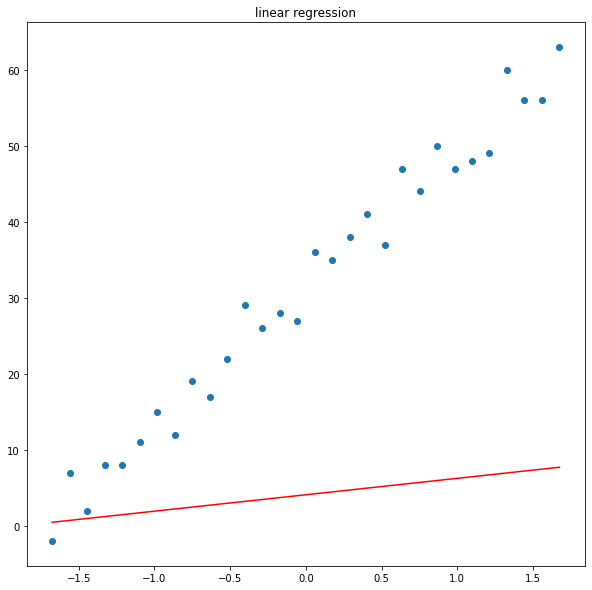

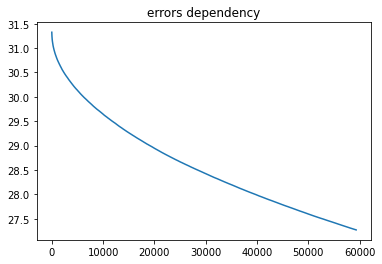

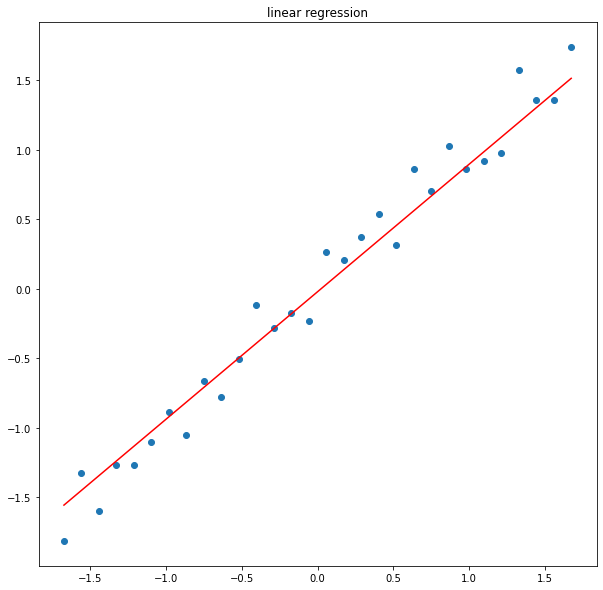

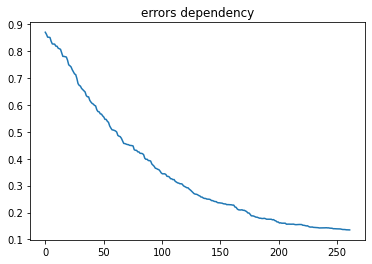

In [403]:
runSGD(TypeOfOptimisation.AdaGrad, withNormalization=False, lr=1e-2, eps=1e-6)
runSGD(TypeOfOptimisation.AdaGrad, withNormalization=True, lr=1e-2, eps=1e-6)

### RMSProp

31.30028701172036 2.5745655493924033
actual coefficients:      [3. 2.]
calculated coefficients:  [30.00395196 17.06687883]
number of iterations:     3913
0.8626203500604745 0.1286308367607271
actual coefficients:      [ 1. -1.]
calculated coefficients:  [0.00318994 0.9731867 ]
number of iterations:     384


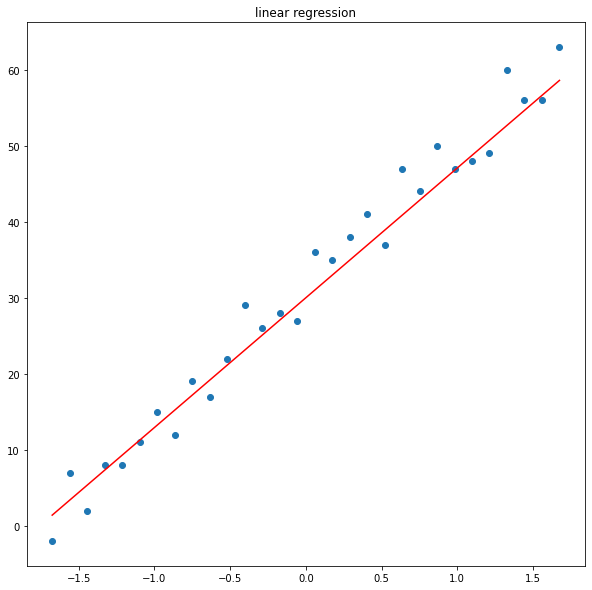

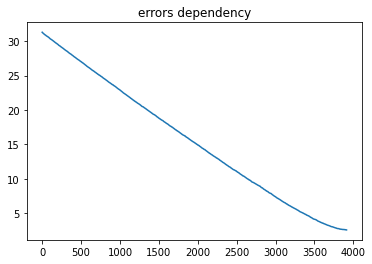

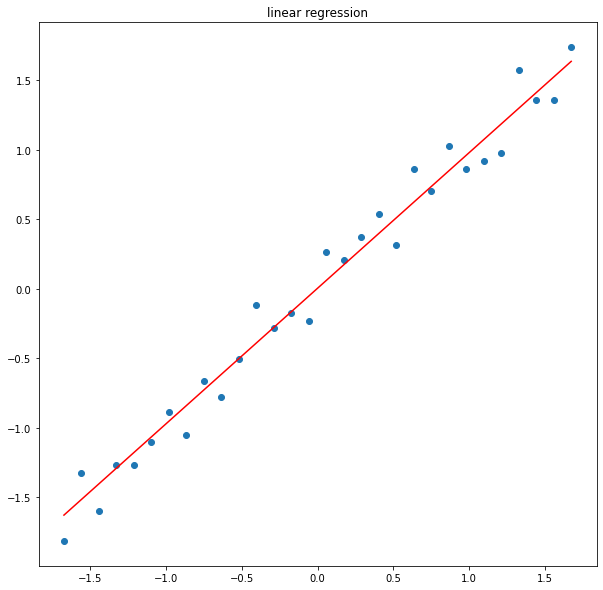

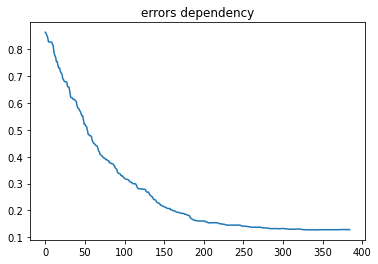

In [404]:
runSGD(TypeOfOptimisation.RMSProp, withNormalization=False, lr=1e-2, eps=1e-6)
runSGD(TypeOfOptimisation.RMSProp, withNormalization=True, lr=1e-2, eps=1e-6)


### Adam

31.3251168312226 2.368790356220055
actual coefficients:      [3. 2.]
calculated coefficients:  [30.7101614  17.72981715]
number of iterations:     14017
0.8703814901929832 0.12935203962642766
actual coefficients:      [ 1. -1.]
calculated coefficients:  [0.01205555 0.99007906]
number of iterations:     516


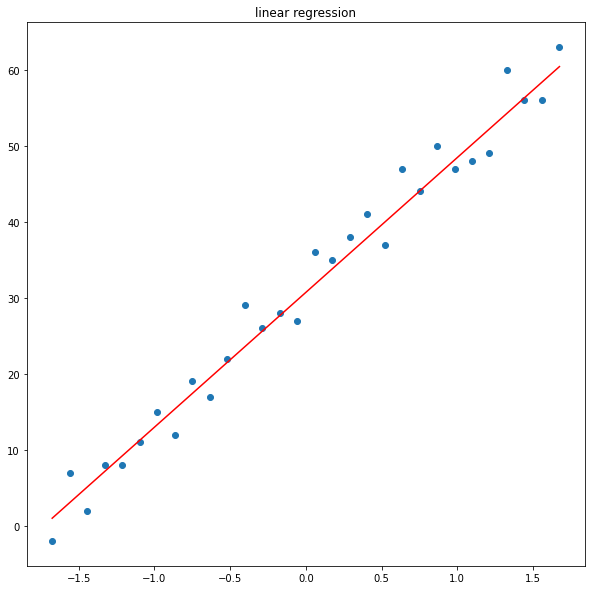

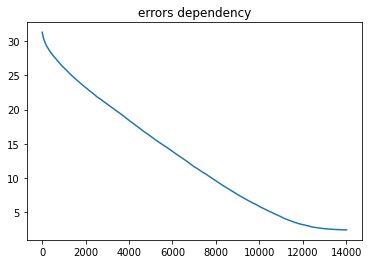

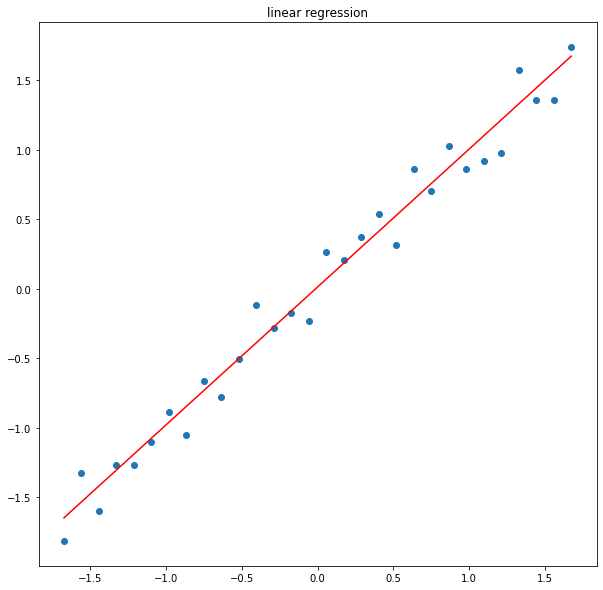

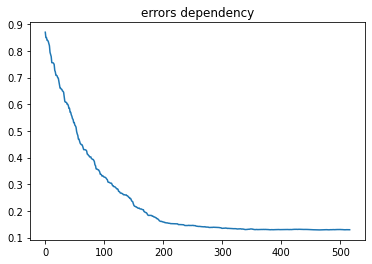

In [405]:
runSGD(TypeOfOptimisation.Adam, withNormalization=False, lr=1e-2, eps=1e-6)
runSGD(TypeOfOptimisation.Adam, withNormalization=True, lr=1e-2, eps=1e-6)

